<p align="center">
  <img src="https://www.climate.gov/sites/default/files/2023-06/ENSOblog_animation_SSTA_anom_weekly_2023_Jun.gif" alt="Weekly Sea Surface Temperature Patterns from NOAA" />
</p>

# Atmospheric Data: Nino 3 SST Index

---

## Overview
Generating a wavelet power and phase spectrum from the time-series data [Nino 3 SST Index](https://psl.noaa.gov/gcos_wgsp/Timeseries/Nino3/)

1. Prerequisties
2. Background
3. Download and Organize Nino 3 SST Data
4. Wavelet Input Values
5. PyWavelets
6. Power Spectrum
7. Phase Spectrum

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Matplotlib](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Necessary | Used to plot data |
| [Intro to Pandas](https://foundations.projectpythia.org/core/pandas/pandas.html) | Necessary | Used to read in and organize data (in particular dataframes) |
| [Intro to Numpy](https://foundations.projectpythia.org/core/numpy/numpy-basics.html)| Necessary | Used to work with large arrays |
| [Intro to SciPy](https://docs.scipy.org/doc/scipy-1.13.1/tutorial/fft.html) | Helpful | Used to work with .wav files and built-in Fast Fourier Transform |

- **Time to learn**: 45 minutes

---

## Background

### What is an El Niño?

[Learn more!](https://oceanservice.noaa.gov/facts/ninonina.html)

### Wavelets and Atmospheric Data

Weather is a great example of time-series data. Weather varies in cycles of temperature over weeks due to a huge vareity of variables. Wavelet analysis can be used to find patterns in temperature by analyzing both the temperature and the time when the temperature occurs.

## Imports

In [2]:
import geocat.datafiles as gcd              # accessing nino3 data file
import xarray as xr                         # working with geocat-datafiles

import numpy as np                          # working with arrays
import pandas as pd                         # working with dataframes
import matplotlib.pyplot as plt             # plot data

import pywt                                 # PyWavelets

## Download Nino 3 SST Data

We will be downloading the `sst_nino3` data from [`geocat-datafiles`](https://github.com/NCAR/geocat-datafiles/tree/main/ascii_files)

In [3]:
nino3_data = gcd.get('ascii_files/sst_nino3.dat')
nino3_data = np.loadtxt(nino3_data)

## Plot and View Data

Let's give the data a look! We have over a hundred years worth of temperature readings.

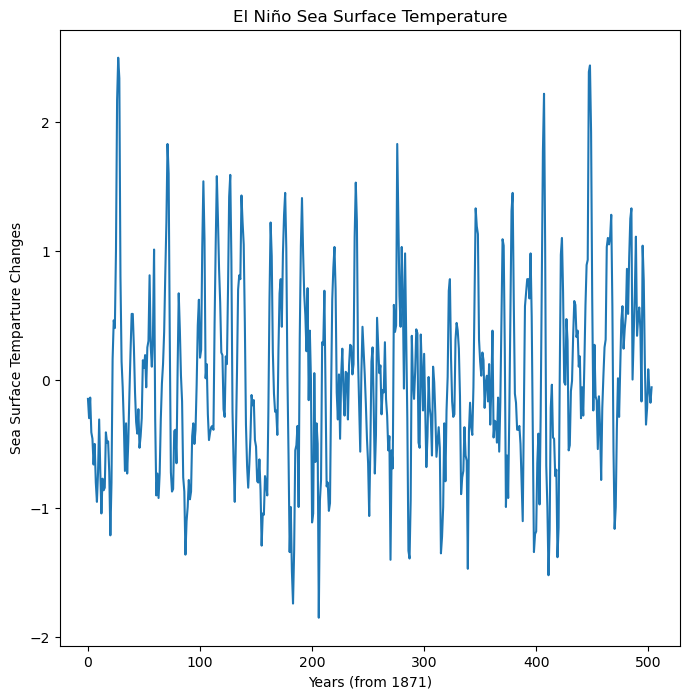

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title("El Niño Sea Surface Temperature")
plt.xlabel("Years (from 1871)")
plt.ylabel("Sea Surface Temparture Changes")
plt.plot(nino3_data)
plt.show()

### Update the X-Axis
By default, the data loaded in lists the year as time since 1871, we can add a new x-axis to view the years along the x-axis

In [5]:
# Convert default X-axis from time steps of 0-504 (0-len(nino3_data)) to Years
dt = 0.25  # sampling period
start_year = 1871
end_year = 1871 + (len(nino3_data) * dt)
x_tickrange = np.arange(start_year, end_year, dt)
start = int(9 / dt)  # 36, starts the x-axis label at 1880 (9 years after start of data)
display_nth = int(20 / dt)  # 80, display x-axis label every 20 years

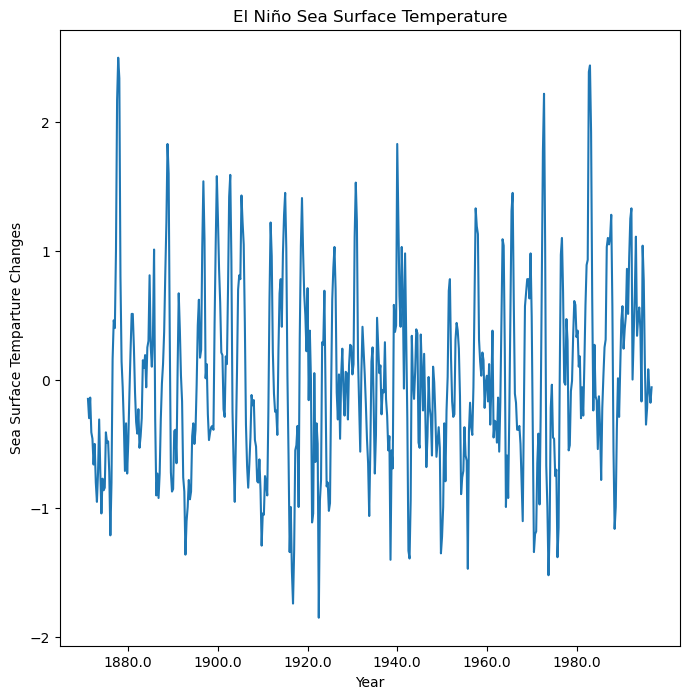

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title("El Niño Sea Surface Temperature")
plt.xlabel("Year")
plt.ylabel("Sea Surface Temparture Changes")
plt.xticks(range(len(x_tickrange))[start::display_nth], x_tickrange[start::display_nth]) # update x-axis
plt.plot(nino3_data)
plt.show()

## Wavelet Input Values

Wavelet inputs include:

- x: Input time-series data (for example, the time and temperature data from nino3)
- wavelet: mother wavelet name
- dt: sampling period (time between each y-value)
- s0: smallest scale
- dj: spacing between each discrete scales
- jtot: largest scale

In [7]:
dt = 0.25  # sampling period (time between each y-value)
s0 = 0.25  # smallest scale
dj = 0.25  # spacing between each discrete scales
jtot = 64  # largest scale

### Define Complex Morlet

A complex Morlet allows us to define both the bandwidth and the center frequency that the Morlet wavelet will be built from to produce optimal results. 

[Here you can learn more about how `PyWavelets` configures Complex Morlet wavelets](https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#wavelet-bandwidth-and-center-frequencies)

Below you can see how changing the bandwith and center frequency will change how the mother Complex Morlet wavelet's shape is formed. The shape of the wavelet will impact which frequencies it is sensitive to.


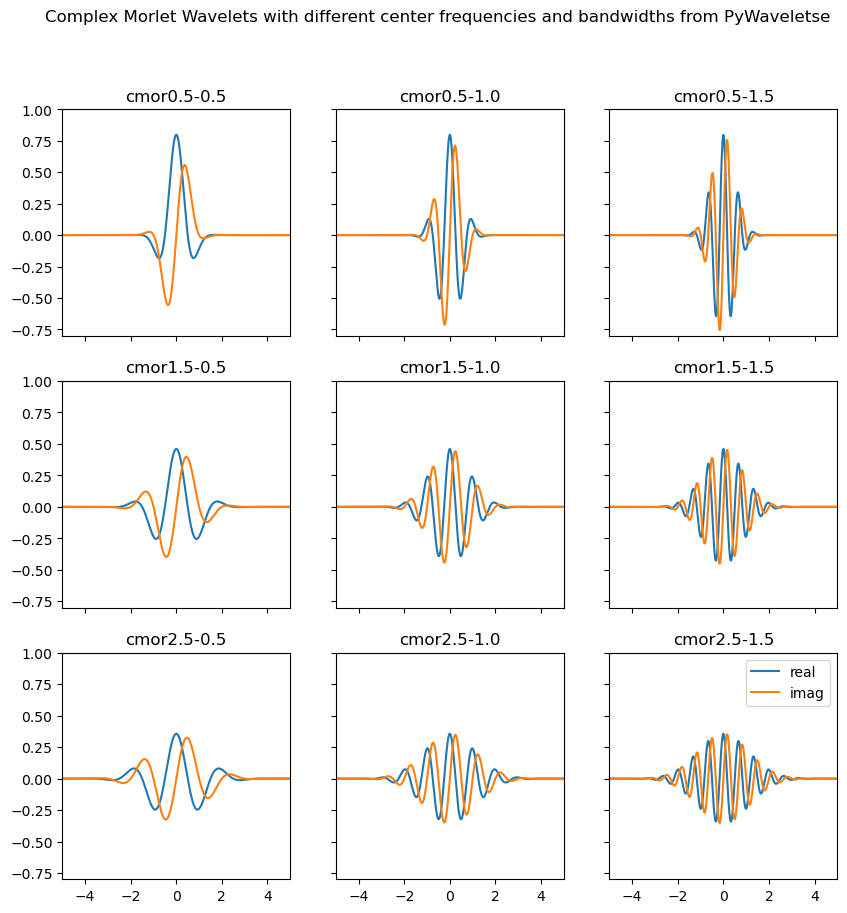

In [8]:
wavelets = [f"cmor{x:.1f}-{y:.1f}" for x in [0.5, 1.5, 2.5] for y in [0.5, 1.0, 1.5]]
fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)
for ax, wavelet in zip(axs.flatten(), wavelets):
    [psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)
    ax.plot(x, np.real(psi), label="real")
    ax.plot(x, np.imag(psi), label="imag")
    ax.set_title(wavelet)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-0.8, 1])
ax.legend()
plt.suptitle("Complex Morlet Wavelets with different center frequencies and bandwidths from PyWaveletse")
plt.show()

Changing the bandwidth and center frequency can be a useful tool to optimize how well the mother wavelet will be able to find frequencies in the data.

Below you will see how different values for bandwidth and center frequency can lead to greater or poorer resolution of the same signal. 

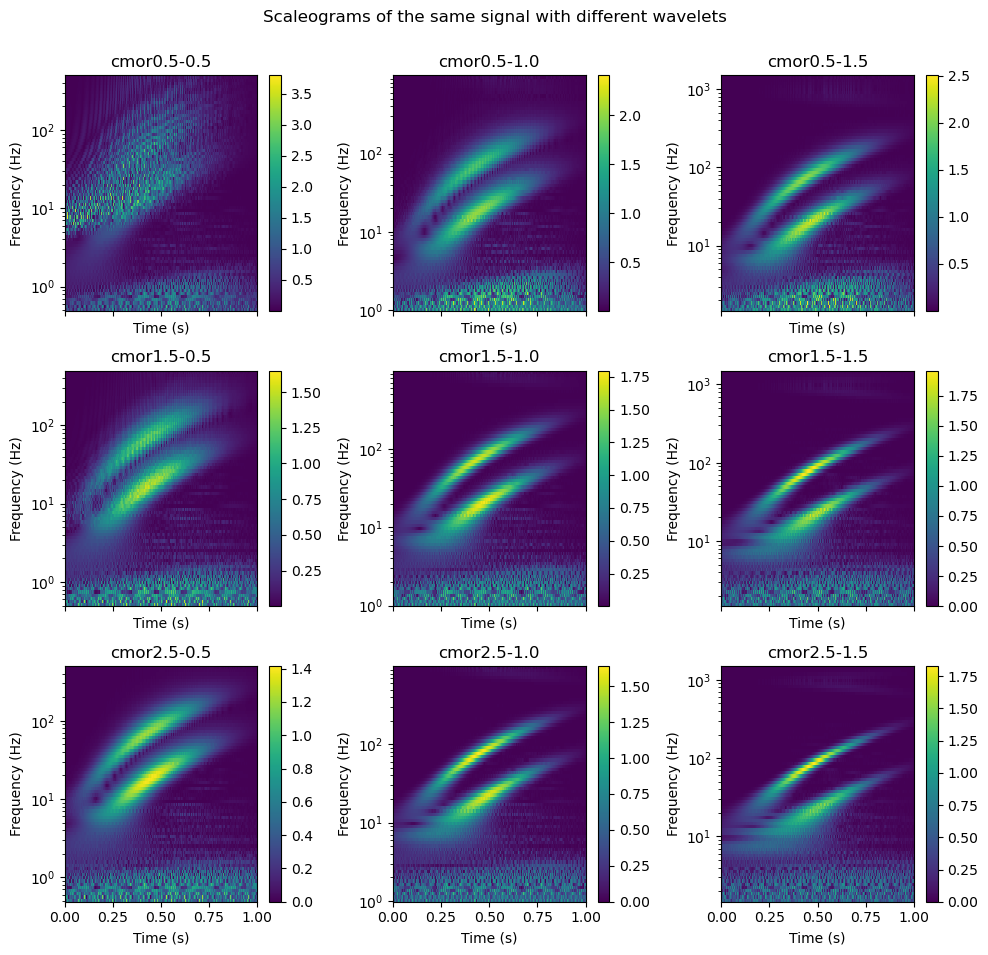

In [17]:
# Code below from: https://pywavelets.readthedocs.io/en/latest/ref/cwt.html

def gaussian(x, x0, sigma):
    return np.exp(-np.power((x - x0) / sigma, 2.0) / 2.0)


def make_chirp(t, t0, a):
    frequency = (a * (t + t0)) ** 2
    chirp = np.sin(2 * np.pi * frequency * t)
    return chirp, frequency


def plot_wavelet(time, data, wavelet, title, ax):
    widths = np.geomspace(1, 1024, num=75)
    cwtmatr, freqs = pywt.cwt(
        data, widths, wavelet, sampling_period=np.diff(time).mean()
    )
    cwtmatr = np.abs(cwtmatr[:-1, :-1])
    pcm = ax.pcolormesh(time, freqs, cwtmatr)
    ax.set_yscale("log")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title(title)
    plt.colorbar(pcm, ax=ax)
    return ax

# generate signal
time = np.linspace(0, 1, 1000)
chirp1, frequency1 = make_chirp(time, 0.2, 9)
chirp2, frequency2 = make_chirp(time, 0.1, 5)
chirp = chirp1 + 0.6 * chirp2
chirp *= gaussian(time, 0.5, 0.2)

# perform CWT with different wavelets on same signal and plot results
wavelets = [f"cmor{x:.1f}-{y:.1f}" for x in [0.5, 1.5, 2.5] for y in [0.5, 1.0, 1.5]]
fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharex=True)
for ax, wavelet in zip(axs.flatten(), wavelets):
    plot_wavelet(time, chirp, wavelet, wavelet, ax)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Scaleograms of the same signal with different wavelets")
plt.show()

**For this example, we will be using a complex Morlet with a bandwidth of 1.5 and a center frequency of 1**

In [9]:
bandwidth = 1.5
center_freq = 1
wavelet_mother = f"cmor{bandwidth}-{center_freq}"
print(wavelet_mother)

cmor1.5-1


## Applying Wavelets

In [10]:
scales = np.arange(1, jtot + 1, dj)
wavelet_coeffs, freqs = pywt.cwt(
    data=nino3_data, scales=scales, wavelet=wavelet_mother, sampling_period=dt
)

## Power Spectrum
The power spectrum is the real component of the wavelet coefficents. We can find this value by squaring the absolute value of the `wavelet_coeffs` to return the magnitude of the real component to better graph.

In [11]:
power = np.power((abs(wavelet_coeffs)), 2)

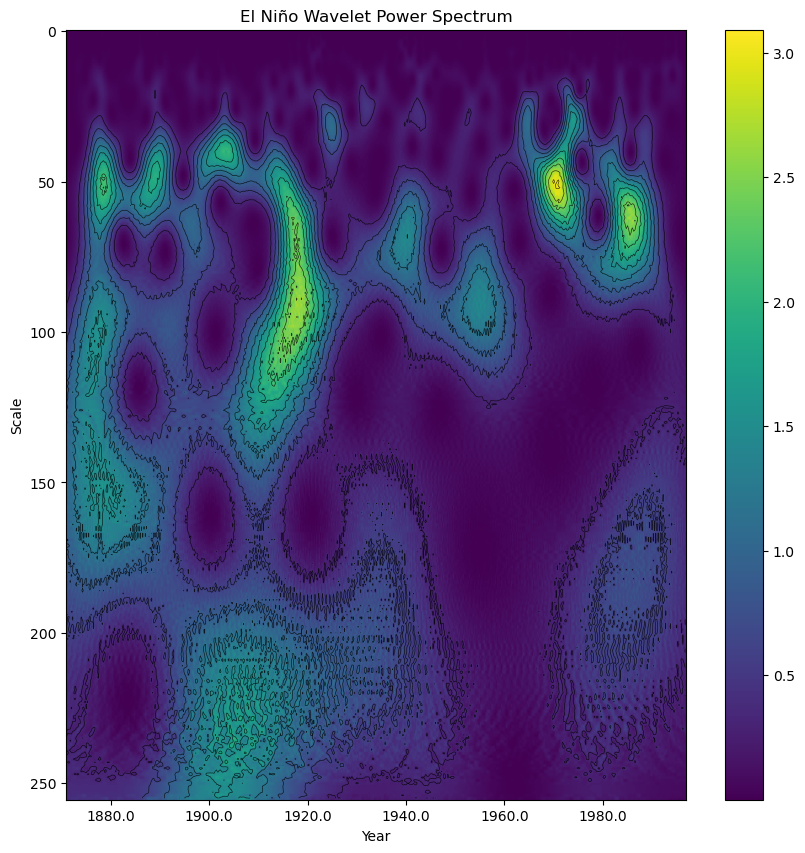

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot contour around data
plt.contour(
    power, vmax=(power).max(), vmin=(power).min(), levels=10
)
plt.contour(power, levels=10, colors="k", linewidths=0.5, alpha=0.75)

# Plot Scalogram
plt.imshow(
    power, vmax=(power).max(), vmin=(power).min(), aspect="auto"
)

plt.xticks(range(len(x_tickrange))[start::display_nth], x_tickrange[start::display_nth])
plt.title("El Niño Wavelet Power Spectrum")
plt.xlabel("Year")
plt.ylabel("Scale")
plt.colorbar()
plt.show()

## Phase Spectrum

While less commonly used, the phase spectrum is the imaginary component of the wavelet.

In [14]:
# compare the phase spectrum
phase = np.angle(wavelet_coeffs)

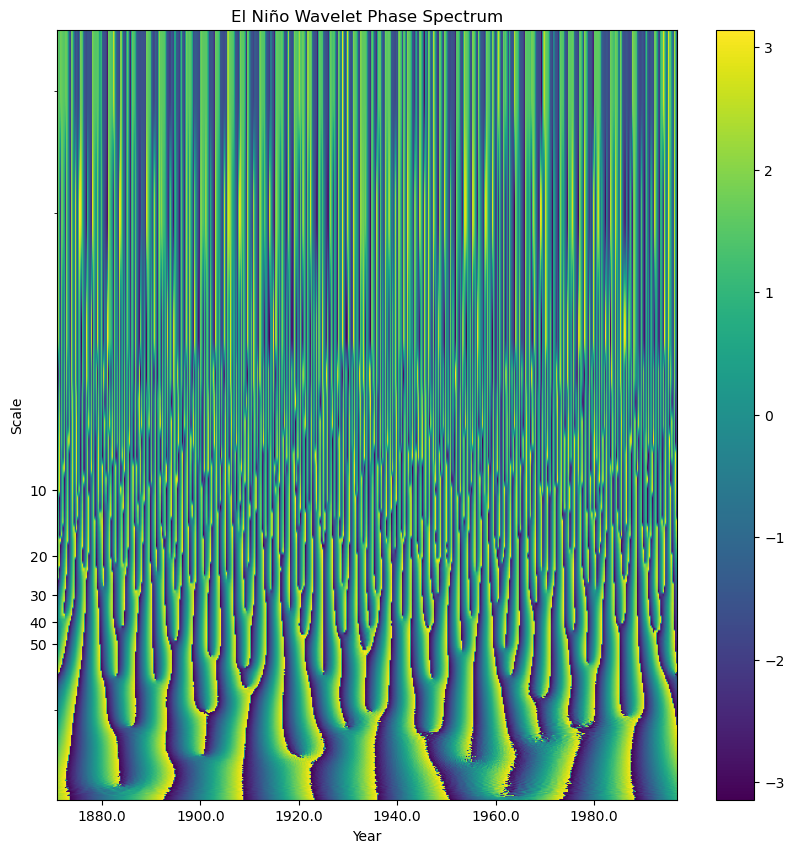

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

# Convert Y-Axis from default to symmetrical log (symlog) with labels
ax.set_yscale("symlog")
ax.invert_yaxis()
ax.set_yticks([10, 20, 30, 40, 50])
ax.set_yticklabels([10, 20, 30, 40, 50])

# Plot scalogram
plt.imshow(
    phase, vmax=(phase).max(), vmin=(phase).min(), aspect="auto"
)

# Convert default X-axis from time steps of 0-504 (0-len(sst_data)) to Years
start_year = 1871
end_year = 1871 + (len(nino3_data) * dt)
x_tickrange = np.arange(start_year, end_year, dt)
start = int(9 / dt)  # 36, starts the x-axis label at 1880 (9 years after start of data)
display_nth = int(20 / dt)  # 80, display x-axis label every 20 years
plt.xticks(range(len(x_tickrange))[start::display_nth], x_tickrange[start::display_nth])

plt.title("El Niño Wavelet Phase Spectrum")
plt.xlabel("Year")
plt.ylabel("Scale")
plt.colorbar()
plt.show()

---

## Summary
Frequency signals appear in more than just audio! A frequency analysis of weather data can inform us about how weather trends change through a year and over a decades worth of data

### What's next?

- [Learn how more about PyWavelets](https://pywavelets.readthedocs.io/en/latest/regression/index.html)


## Resources and references

- ["A Practical Guide to Wavelet Analysis" (Torrence and Compo, 1998)](https://psl.noaa.gov/people/gilbert.p.compo/Torrence_compo1998.pdf)